# Pre Processing the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree

mpl.rcParams['figure.dpi']= 75  # set the resolution of displayed figures
mpl.rc("savefig", dpi=150) # set the resolution of saved figures
plt.style.use('seaborn-v0_8')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/american_bankruptcy.csv', delimiter=',')
df.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [ ]:
rows, columns = df.shape
print(f"Rows: {rows}, Columns: {columns}")

Rows: 78682, Columns: 21


# Data Resampling

<ipython-input-175-df3809eb8cae>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette=['b', 'red'])


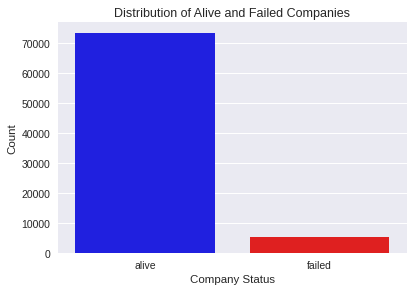

Ratio of Alive to Failed Companies: 14.073180076628352


In [ ]:
# Bar Chart for Original Dataset
statuses = df['status_label'].unique()
status_counts = df['status_label'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=status_counts.index, y=status_counts.values, palette=['b', 'red'])
plt.xlabel("Company Status")
plt.ylabel("Count")
plt.title("Distribution of Alive and Failed Companies")
plt.show()

alive_count = status_counts['alive']
failed_count = status_counts['failed']
ratio_alive_to_failed = alive_count / failed_count

print("Ratio of Alive to Failed Companies:", ratio_alive_to_failed)

In [ ]:
df = df.rename(columns={
    'X1': 'current assets',
    'X2': 'cost of goods sold',
    'X3': 'depreciation & amortization',
    'X4': 'earnings EBITDA',
    'X5': 'inventory',
    'X6': 'net income',
    'X7': 'total receivables',
    'X8': 'market value',
    'X9': 'net sales',
    'X10': 'total assets',
    'X11': 'total long-term debt',
    'X12': 'earnings EBIT',
    'X13': 'gross profits',
    'X14': 'total current liabilities',
    'X15': 'retained earnings',
    'X16': 'total revenue',
    'X17': 'total liabilities',
    'X18': 'total operating expenses',

})

Because our binary output variable is imbalanced with much more 'Alive' than 'Failed' (from the bar chart above), we want to downsample 'Alive' lables in the training set.

# Downsampling of Data

In [ ]:
from sklearn.utils import resample

# Splitting train & test set
train_df, test_df = train_test_split(
    df,
    test_size = 0.20, # 80/20 split
    stratify = df['status_label'],
    random_state= 42
)

alive = train_df[train_df.status_label == 'alive']
failed = train_df[train_df.status_label == 'failed']

alive_down = resample(
    alive,
    replace = False,
    n_samples = 8000, # downsample alive to 8000
    random_state = 42
)

train_bal = (pd.concat([failed, alive_down])
               .sample(frac=1, random_state=42)
               .reset_index(drop=True))
predictors = train_bal.columns.drop(['company_name','year','status_label'])

# Training & test sets
X_train = train_bal[predictors]
y_train = train_bal.status_label.map({'failed':0, 'alive':1})

X_test  = test_df[predictors]
y_test  = test_df.status_label .map({'failed':0, 'alive':1})

print(train_bal.status_label.value_counts())


status_label
alive     8000
failed    4176
Name: count, dtype: int64


<ipython-input-178-cb1f7e1cb650>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts_bal.index,


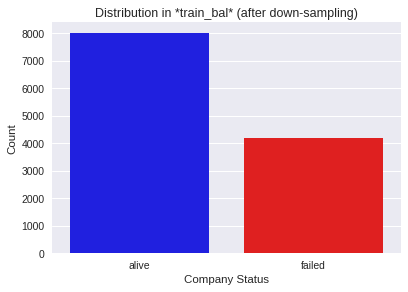

Ratio of Alive to Failed Companies in Balanced Dataset: 4176 / 8000 = 0.522


In [ ]:
status_counts_bal = train_bal['status_label'].value_counts()

# New Bar Chart after resampling
plt.figure(figsize=(6,4))
sns.barplot(x=status_counts_bal.index,
            y=status_counts_bal.values,
            palette=['b','red'])
plt.xlabel("Company Status")
plt.ylabel("Count")
plt.title("Distribution in *train_bal* (after down-sampling)")
plt.show()

alive_count_bal = status_counts_bal['alive']
failed_count_bal = status_counts_bal['failed']

# Calculate the ratio
ratio_alive_to_failed_bal = failed_count_bal / alive_count_bal

print("Ratio of Alive to Failed Companies in Balanced Dataset:",failed_count_bal, "/", alive_count_bal, "=", ratio_alive_to_failed_bal)


In [ ]:
alive_count = status_counts_bal['alive']
failed_count = status_counts_bal['failed']
print(alive_count)
print(failed_count)
total_count = status_counts_bal.sum()

ratio = alive_count / 78682
print("This is the ratio of thriving companies compared to rest of dataset", ratio)

8000
4176
This is the ratio of thriving companies compared to rest of dataset 0.10167509722681173


# Descriptive Statistics & Data Cleaning

In [ ]:
df.describe()

,year,current assets,cost of goods sold,depreciation & amortization,earnings EBITDA,inventory,net income,total receivables,market value,net sales,total assets,total long-term debt,earnings EBIT,gross profits,total current liabilities,retained earnings,total revenue,total liabilities,total operating expenses
count,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,7.868200e+04,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000
mean,2007.506317,880.362485,1594.529029,121.234256,376.759424,201.605717,129.382453,286.832743,3.414355e+03,2364.019706,2867.110620,722.483710,255.525035,769.490783,610.072255,532.467069,2364.019706,1773.563963,1987.260307
std,5.742768,3928.564794,8930.484664,652.376804,2012.023142,1060.766096,1265.532022,1335.978571,1.841410e+04,11950.068842,12917.944421,3242.170946,1494.643534,3774.703114,2938.387443,6369.159440,11950.068842,8053.684902,10419.629038
min,1999.000000,-7.760000,-366.645000,0.000000,-21913.000000,0.000000,-98696.000000,-0.006000,1.000000e-04,-1964.999000,0.001000,-0.023000,-25913.000000,-21536.000000,0.001000,-102362.000000,-1964.999000,0.001000,-317.197000
25%,2002.000000,18.924000,17.038250,1.192000,-0.811000,0.000000,-7.415750,3.281250,3.498000e+01,27.548500,37.363500,0.000000,-2.787000,8.521250,8.889250,-68.282750,27.548500,13.486000,32.872500
50%,2007.000000,100.449500,103.661000,7.929500,15.034500,7.023000,1.616000,22.820000,2.275118e+02,186.598500,213.203500,7.593500,6.518000,63.581500,43.333000,-1.131000,186.598500,81.988000,168.912000
75%,2012.000000,431.526750,634.548000,47.971750,139.655250,74.747250,40.144250,131.580500,1.244890e+03,1046.402500,1171.364750,248.760750,87.599000,344.074250,222.817000,146.070000,1046.402500,629.975000,875.522250
max,2018.000000,169662.000000,374623.000000,28430.000000,81730.000000,62567.000000,104821.000000,65812.000000,1.073391e+06,511729.000000,531864.000000,166250.000000,71230.000000,137106.000000,116866.000000,402089.000000,511729.000000,337980.000000,481580.000000


Because the sum of X4 (Earnings before interest, taxes, depreciation, and amortization) and X18 (Total Operating Expenses) will be X9 (Net Sales), we choose to drop X9 here.

Also, because X9 (Net Sales) and X16 (Total Revenue) have exactly the same value in this dataset (so their correlation = 1.00), we need to drop both.

In [ ]:
predictors = df.drop('net income', axis=1) #X9
predictors = df.drop('total revenue', axis=1) #X16

In [ ]:
df.describe() # The Dataset After dropping X9 & X16

,year,current assets,cost of goods sold,depreciation & amortization,earnings EBITDA,inventory,net income,total receivables,market value,net sales,total assets,total long-term debt,earnings EBIT,gross profits,total current liabilities,retained earnings,total revenue,total liabilities,total operating expenses
count,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,7.868200e+04,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000
mean,2007.506317,880.362485,1594.529029,121.234256,376.759424,201.605717,129.382453,286.832743,3.414355e+03,2364.019706,2867.110620,722.483710,255.525035,769.490783,610.072255,532.467069,2364.019706,1773.563963,1987.260307
std,5.742768,3928.564794,8930.484664,652.376804,2012.023142,1060.766096,1265.532022,1335.978571,1.841410e+04,11950.068842,12917.944421,3242.170946,1494.643534,3774.703114,2938.387443,6369.159440,11950.068842,8053.684902,10419.629038
min,1999.000000,-7.760000,-366.645000,0.000000,-21913.000000,0.000000,-98696.000000,-0.006000,1.000000e-04,-1964.999000,0.001000,-0.023000,-25913.000000,-21536.000000,0.001000,-102362.000000,-1964.999000,0.001000,-317.197000
25%,2002.000000,18.924000,17.038250,1.192000,-0.811000,0.000000,-7.415750,3.281250,3.498000e+01,27.548500,37.363500,0.000000,-2.787000,8.521250,8.889250,-68.282750,27.548500,13.486000,32.872500
50%,2007.000000,100.449500,103.661000,7.929500,15.034500,7.023000,1.616000,22.820000,2.275118e+02,186.598500,213.203500,7.593500,6.518000,63.581500,43.333000,-1.131000,186.598500,81.988000,168.912000
75%,2012.000000,431.526750,634.548000,47.971750,139.655250,74.747250,40.144250,131.580500,1.244890e+03,1046.402500,1171.364750,248.760750,87.599000,344.074250,222.817000,146.070000,1046.402500,629.975000,875.522250
max,2018.000000,169662.000000,374623.000000,28430.000000,81730.000000,62567.000000,104821.000000,65812.000000,1.073391e+06,511729.000000,531864.000000,166250.000000,71230.000000,137106.000000,116866.000000,402089.000000,511729.000000,337980.000000,481580.000000


# Correlation Matrix

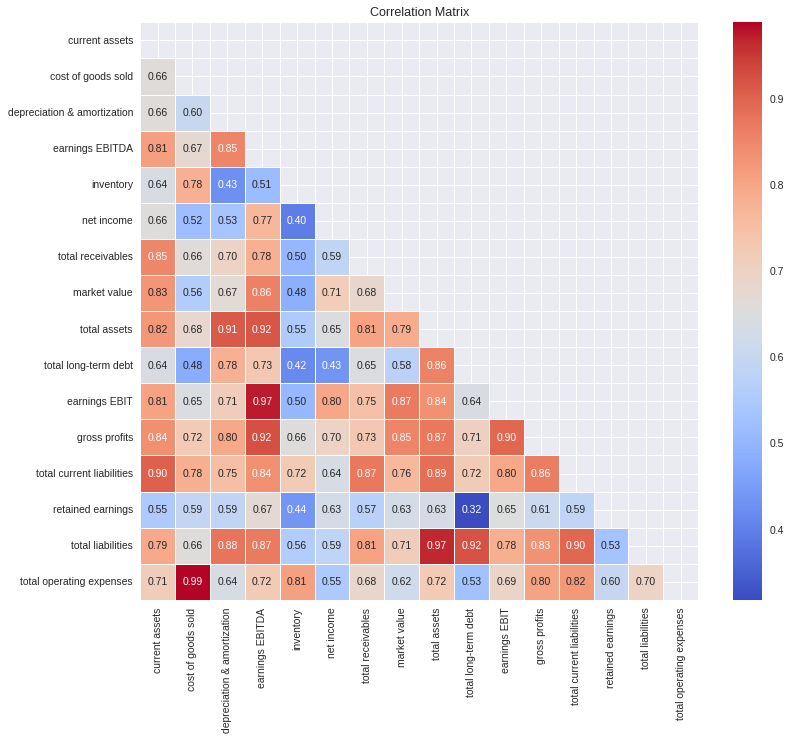

In [ ]:
predictors = [
    'current assets',
    'cost of goods sold',
    'depreciation & amortization',
    'earnings EBITDA',
    'inventory',
    'net income',
    'total receivables',
    'market value',
    'total assets',
    'total long-term debt',
    'earnings EBIT',
    'gross profits',
    'total current liabilities',
    'retained earnings',
    'total liabilities',
    'total operating expenses'
]


data = df[predictors]
correlation_matrix = data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Correlation Matrix')
plt.show()

Highly Correlated
- cost of goods sold & total operating expenses
- earnings EBITDA & earnings EBIT
- total assets & total liabilities

# Boxplot (Company status vs. Net income)

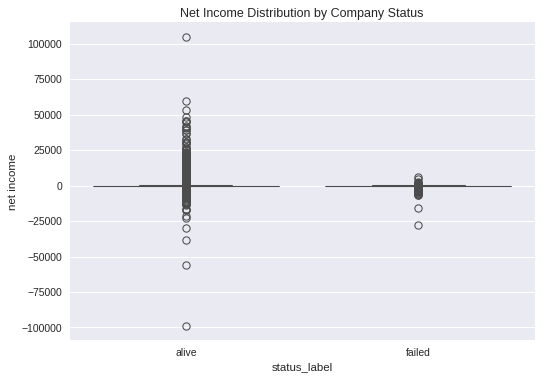

In [ ]:
sns.boxplot(x=df['status_label'], y=df['net income'])
plt.title("Net Income Distribution by Company Status")
plt.show()

# Scatterplot (Total Revenue vs. Net Income)

In [ ]:
print(df.columns.tolist())

['company_name', 'status_label', 'year', 'current assets', 'cost of goods sold', 'depreciation & amortization', 'earnings EBITDA', 'inventory', 'net income', 'total receivables', 'market value', 'net sales', 'total assets', 'total long-term debt', 'earnings EBIT', 'gross profits', 'total current liabilities', 'retained earnings', 'total revenue', 'total liabilities', 'total operating expenses']


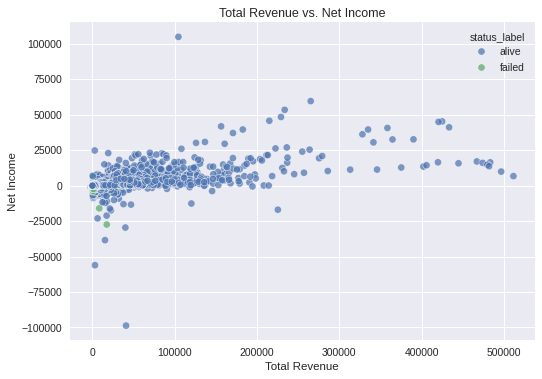

In [ ]:
sns.scatterplot(data=df,x='total revenue',y='net income',hue='status_label',alpha=0.7)
plt.title("Total Revenue vs. Net Income")
plt.xlabel("Total Revenue")
plt.ylabel("Net Income")
plt.show()

# Logistic Regression

In [ ]:
# We choose logistic regression over linear regression for binary outcome variable
lr = LogisticRegression()
lr.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Logistic Regression MSE & Accuracy
yhat_test_lr = lr.predict(X_test)
round(mean_squared_error(y_test, yhat_test_lr),4)
print("Logistic Regression MSE =", mean_squared_error(y_test, yhat_test_lr))

accuracy_lr = accuracy_score(y_test, yhat_test_lr)
print("Logistic Regression Model Accuracy =", accuracy_lr)

# confusion matrix
confusion_matrix(y_test, yhat_test_lr)

# classification report
print("Classification Report:\n", classification_report(y_test, yhat_test_lr))

Logistic Regression MSE = 0.17303170871195273
Logistic Regression Model Accuracy = 0.8269682912880473
Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.31      0.19      1044
           1       0.95      0.86      0.90     14693

    accuracy                           0.83     15737
   macro avg       0.54      0.59      0.55     15737
weighted avg       0.89      0.83      0.86     15737



# Standardization

In [ ]:
scaler       = StandardScaler().fit(X_train)
x_train_std  = scaler.transform(X_train)
x_test_std   = scaler.transform(X_test)

# Checking for Multicollinearity

In [ ]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculating VIF - the indicator of multicollinearity

X = X_train[predictors]
X = sm.add_constant(X) # add a column for constants only
vif_data = pd.DataFrame() # dataframe for all vif values
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# see which predictors have vif >10
high_vif = vif_data[vif_data["VIF"] > 10]
print("Features with VIF > 10:")
print(high_vif)

Features with VIF > 10:
                        feature        VIF
1                current assets  10.284220
2            cost of goods sold        inf
3   depreciation & amortization        inf
4               earnings EBITDA        inf
9                  total assets  46.927487
10         total long-term debt  15.834995
11                earnings EBIT        inf
12                gross profits        inf
13    total current liabilities  20.794290
15            total liabilities  70.385540
16     total operating expenses        inf


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [ ]:
# highly correlated variables, dropped
predictors = df.drop('earnings EBIT', axis=1)
predictors = df.drop('total assets', axis=1)
# EBIT is smaller than earnings EBITDA so we drop one of them
# Total assets has high correlations with total liabilities


# Cross-Validation Imports

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, Ridge

# set up 5-fold CV
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Ridge

In [ ]:
alphas = np.logspace(-4, 3, 1000)

# pipeline
ridge_cv_pipe = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=alphas, cv=cv5, scoring='neg_mean_squared_error')
)
ridge_cv_pipe.fit(X_train, y_train)

best_alpha = ridge_cv_pipe.named_steps['ridgecv'].alpha_
print("best alpha:", best_alpha)

# ridge coefficients
coefs = pd.Series(
    ridge_cv_pipe.named_steps['ridgecv'].coef_,
    index=X_train.columns
)
print("\nAll Ridge coefficients:\n", coefs)

# important predictors
selected = list(coefs[coefs.abs() > 1e-6].index)

y_pred_cont = ridge_cv_pipe.predict(X_test)
y_pred_bin  = (y_pred_cont >= 0.5).astype(int)

print("\nConfusion Matrix:\n",
      confusion_matrix(y_test, y_pred_bin))
print("\nClassification Report:\n",
      classification_report(y_test, y_pred_bin,target_names=['failed','alive']))

best alpha: 104.47659715608053

All Ridge coefficients:
 X1    -0.005290
X2    -0.013024
X3    -0.042820
X4    -0.007283
X5     0.013710
X6     0.025888
X7     0.046025
X8     0.026351
X9    -0.003698
X10    0.079526
X11    0.003084
X12    0.008486
X13    0.019820
X14   -0.031819
X15   -0.014693
X16   -0.003698
X17   -0.064557
X18   -0.002776
dtype: float64

Confusion Matrix:
 [[    9  1035]
 [   38 14655]]

Classification Report:
               precision    recall  f1-score   support

      failed       0.19      0.01      0.02      1044
       alive       0.93      1.00      0.96     14693

    accuracy                           0.93     15737
   macro avg       0.56      0.50      0.49     15737
weighted avg       0.88      0.93      0.90     15737



In [ ]:
# Similar method but using pipeline (without doing CV)
from sklearn.pipeline import make_pipeline

ridge_pipe = make_pipeline(StandardScaler(), Ridge(alpha=0.1))
ridge_pipe.fit(X_train, y_train)
ridge_pipe['ridge'].coef_ #use lowercase for 'R'idge

array([-0.01585865, -0.01603617, -0.05640993, -0.00886393,  0.01233271,
        0.02242004,  0.05283806,  0.02063018, -0.00334011,  0.1327624 ,
        0.01409155,  0.01217107,  0.02835387, -0.02427278, -0.01835997,
       -0.00334011, -0.11720741, -0.00201151])

In [ ]:
ridge = Ridge(alpha=0.1)
ridge.fit(x_train_std, y_train)

# Ridge Test MSE
yhat_test_rg = ridge.predict(x_test_std)
round(mean_squared_error(y_test,yhat_test_rg),4)
print("Ridge test MSE =", mean_squared_error(y_test,yhat_test_rg))

# Ridge Model Accuracy: Threshold = 0.5
yhat_test_rg_binary = (yhat_test_rg >= 0.5).astype(int) # turn predicted y values into binary
accuracy_rg = accuracy_score(y_test, yhat_test_rg_binary)
print("Ridge Accuracy =", accuracy_rg)

# confusion matrix - ridge
confusion_matrix(y_test, yhat_test_rg_binary)

# classification report - ridge
print("Classification Report:\n", classification_report(y_test, yhat_test_rg_binary))

Ridge test MSE = 0.13921486499431288
Ridge Accuracy = 0.9314990150600496
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.01      0.02      1044
           1       0.93      1.00      0.96     14693

    accuracy                           0.93     15737
   macro avg       0.57      0.50      0.49     15737
weighted avg       0.89      0.93      0.90     15737



# Lasso

In [ ]:
from sklearn.linear_model  import LassoCV

alphas = np.logspace(-4, -1, 30)

lasso_cv_pipe = make_pipeline(
    StandardScaler(),
    LassoCV(alphas=alphas, cv=cv5, random_state=42, max_iter=10_000)
)
lasso_cv_pipe.fit(X_train, y_train)

best_alpha = lasso_cv_pipe.named_steps['lassocv'].alpha_
print("Best Lasso alpha:", round(best_alpha, 6))

# lasso coefficients
coefs = pd.Series(
    data=lasso_cv_pipe.named_steps['lassocv'].coef_,
    index=X_train.columns
)
selected = list(coefs[coefs != 0].index)
print("selected predictors:", selected) # they're the most relevant predictors to y

y_pred_cont = lasso_cv_pipe.predict(X_test)
y_pred_bin  = (y_pred_cont >= 0.5).astype(int)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bin))
print("\nClassification Report:\n",
      classification_report(y_test, y_pred_bin, target_names=['failed','alive']))

Best Lasso alpha: 0.000853
selected predictors: ['cost of goods sold', 'depreciation & amortization', 'inventory', 'net income', 'total receivables', 'market value', 'total assets', 'gross profits', 'total current liabilities', 'retained earnings', 'total liabilities']

Confusion Matrix:
 [[    8  1036]
 [   35 14658]]

Classification Report:
               precision    recall  f1-score   support

      failed       0.19      0.01      0.01      1044
       alive       0.93      1.00      0.96     14693

    accuracy                           0.93     15737
   macro avg       0.56      0.50      0.49     15737
weighted avg       0.88      0.93      0.90     15737



# KNN

In [ ]:
# Find the best k for kNN using CV
best_score = 0
best_k = None

for k in range(1, 21):
    knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    scores = cross_val_score(knn, X_train, y_train, cv=5) # CV
    avg_score = scores.mean()
    if avg_score > best_score:
        best_score = avg_score
        best_k = k

print(f"Best k based on CV = {best_k} with CV accuracy = {best_score:.4f}")

Best k based on CV = 1 with CV accuracy = 0.7530


In [ ]:
# best k = 1
knn_clf = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=1))
knn_clf.fit(X_train, y_train)

yhat_knn = knn_clf.predict(X_test)

print(f"KNN Test Accuracy: {accuracy_score(y_test, yhat_knn):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, yhat_knn))
print("\nClassification Report:\n",
      classification_report(y_test, yhat_knn,
                            target_names=['failed','alive']))


KNN Test Accuracy: 0.7914
Confusion Matrix:
 [[  750   294]
 [ 2989 11704]]

Classification Report:
               precision    recall  f1-score   support

      failed       0.20      0.72      0.31      1044
       alive       0.98      0.80      0.88     14693

    accuracy                           0.79     15737
   macro avg       0.59      0.76      0.60     15737
weighted avg       0.92      0.79      0.84     15737



# Random Forest: Classification

In [ ]:
from sklearn.ensemble   import RandomForestClassifier
from sklearn.metrics    import classification_report, recall_score
from sklearn.pipeline   import make_pipeline
from sklearn.preprocessing import StandardScaler

# build a pipeline that scales and fits a class-weighted RF
rf_clf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=200,
        class_weight={0:10, 1:1},   # give failures 10 times more weight
        random_state=42,
        n_jobs=-1
    )
)

# fit on original training data
rf_clf.fit(X_train, y_train)

# predict on the test set
yhat_rf = rf_clf.predict(X_test)

# evaluate recall on failures and full report
print(f"RF Test Accuracy: {accuracy_score(y_test, yhat_rf):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, yhat_rf))
print(
    "\nClassification Report:\n",
    classification_report(
        y_test,
        yhat_rf,
        target_names=['failed','alive']
    )
)


RF Test Accuracy: 0.8885
Confusion Matrix:
 [[  494   550]
 [ 1205 13488]]

Classification Report:
               precision    recall  f1-score   support

      failed       0.29      0.47      0.36      1044
       alive       0.96      0.92      0.94     14693

    accuracy                           0.89     15737
   macro avg       0.63      0.70      0.65     15737
weighted avg       0.92      0.89      0.90     15737



# Classification Tree


=== Results for alpha = 0.0001 ===
Confusion Matrix:
 [[  287   757]
 [ 1468 13225]]
Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.27      0.21      1044
           1       0.95      0.90      0.92     14693

    accuracy                           0.86     15737
   macro avg       0.55      0.59      0.56     15737
weighted avg       0.89      0.86      0.87     15737

Accuracy: 0.8586134587278389

=== Results for alpha = 5e-05 ===
Confusion Matrix:
 [[  287   757]
 [ 1468 13225]]
Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.27      0.21      1044
           1       0.95      0.90      0.92     14693

    accuracy                           0.86     15737
   macro avg       0.55      0.59      0.56     15737
weighted avg       0.89      0.86      0.87     15737

Accuracy: 0.8586134587278389

=== Results for alpha = 1e-05 ===
Confusion Matrix:
 [[  287   757]


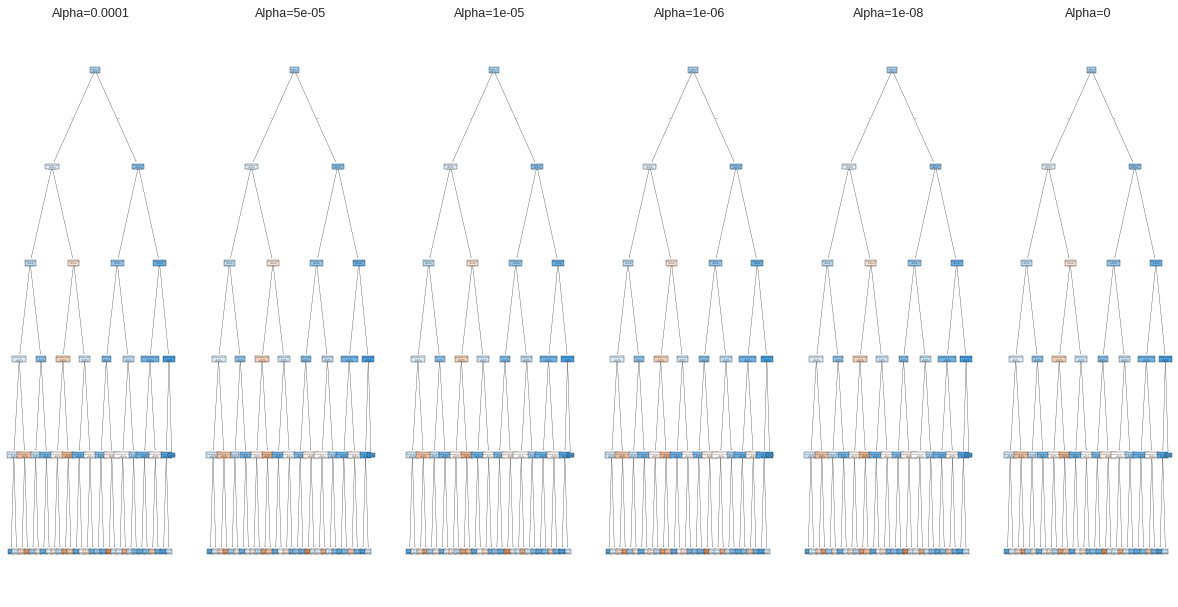

In [ ]:
fig = plt.figure(figsize=(20,10))
alphas = [0.0001, 0.00005, 0.00001, 0.000001, 0.00000001, 0]
ctr = 1

# looping through alphas
for alpha in alphas:
    dt = DecisionTreeClassifier(
        ccp_alpha=alpha,
        max_depth=5,
        min_samples_split=15,
        min_samples_leaf=5
    )
    dt.fit(X_train, y_train)

    plt.subplot(1, len(alphas), ctr)
    tree.plot_tree(dt, feature_names=X_train[predictors].columns.tolist(), filled=True)
    plt.title(f"Alpha={alpha}")
    ctr += 1

    yhat_dt = dt.predict(X_test[predictors])
    print(f"\n=== Results for alpha = {alpha} ===")
    print("Confusion Matrix:\n", confusion_matrix(y_test, yhat_dt))
    print("Classification Report:\n", classification_report(y_test, yhat_dt))
    print("Accuracy:", accuracy_score(y_test, yhat_dt))

Alpha = 0.0001: Mean CV Accuracy = 0.6838035558342859
Alpha = 5e-05: Mean CV Accuracy = 0.6838035558342859
Alpha = 1e-05: Mean CV Accuracy = 0.6838035558342859
Alpha = 1e-06: Mean CV Accuracy = 0.6838035558342859
Alpha = 1e-08: Mean CV Accuracy = 0.6838035558342859
Alpha = 0: Mean CV Accuracy = 0.6838035558342859


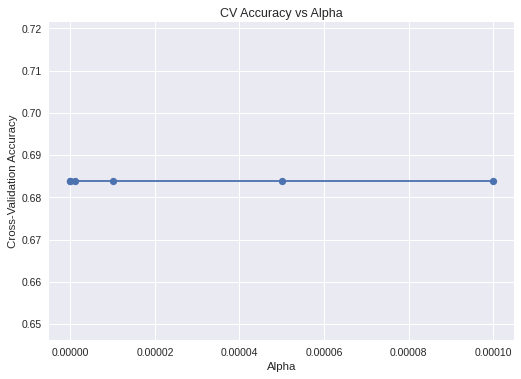

In [161]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV
cv_scores = []
alphas = [0.0001, 0.00005, 0.00001, 0.000001, 0.00000001, 0]

# Loop through different alphas
for alpha in alphas:
    dt = DecisionTreeClassifier(
        ccp_alpha=alpha,
        max_depth=5,
        min_samples_split=15,
        min_samples_leaf=5
    )

    # Perform cross-validation and get accuracy scores for each fold
    scores = cross_val_score(dt, X_train[predictors], y_train, cv=cv, scoring='accuracy')
    cv_scores.append(np.mean(scores))
    print(f"Alpha = {alpha}: Mean CV Accuracy = {np.mean(scores)}")

# Plot the accuracy for different alphas
plt.plot(alphas, cv_scores, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation Accuracy')
plt.title('CV Accuracy vs Alpha')
plt.show()

Confusion Matrix:
 [[  287   757]
 [ 1468 13225]]

Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.27      0.21      1044
           1       0.95      0.90      0.92     14693

    accuracy                           0.86     15737
   macro avg       0.55      0.59      0.56     15737
weighted avg       0.89      0.86      0.87     15737


Accuracy: 0.8586134587278389


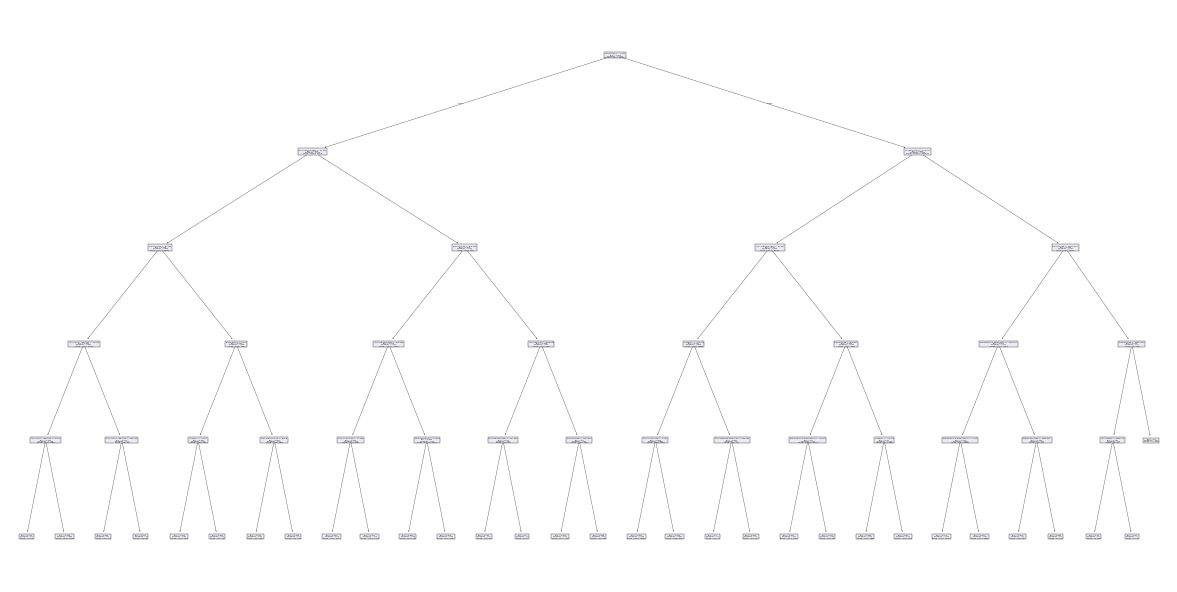

In [ ]:
fig = plt.figure(figsize=(20,10))
alphas = [0.0001]
#new_predictors = ['X1', 'X2', 'X3', 'X5', 'X6', 'X7', 'X8', 'X10', 'X11', 'X12', 'X13', 'X15', 'X16', 'X17']
ctr=1
# try different alphas to see the effect on tree size
for alpha in alphas:
  dt = DecisionTreeClassifier(
        ccp_alpha=alpha,
        max_depth=5,
        min_samples_split=15,
        min_samples_leaf=5
    )
  dt.fit(X_train, y_train)
  plt.subplot(1, len(alphas), ctr)
  tree.plot_tree(dt, feature_names=X_train[predictors].columns.tolist())
  yhat_dt = dt.predict(X_test)
  ctr+=1


print("Confusion Matrix:\n", confusion_matrix(y_test, yhat_dt))
print("\nClassification Report:\n", classification_report(y_test, yhat_dt))
print("\nAccuracy:", accuracy_score(y_test, yhat_dt))



In [ ]:
dt.feature_importances_

array([0.06182948, 0.01641572, 0.06534578, 0.        , 0.01067256,
       0.05681944, 0.28947747, 0.03262692, 0.14553845, 0.00227745,
       0.19972825, 0.02907014, 0.04150512, 0.01111145, 0.02665883,
       0.01092294])

# Boosting

In [160]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score


boost_xgb = XGBClassifier(
   n_estimators=100,   # number of trees
   max_depth=3,        # maximum depth of each tree
   learning_rate=0.01, # how fast the model adapts
   random_state=42     # for reproducibility
)


boost_xgb.fit(X_train.values, y_train.values)


# Predict and evaluate
yhat_boost = boost_xgb.predict(X_test.values)


# Evaluation
print("Accuracy:", accuracy_score(y_test, yhat_boost))
print("Confusion Matrix:\n", confusion_matrix(y_test, yhat_boost))
print("Classification Report:\n", classification_report(y_test, yhat_boost))


X_train_array = X_train.values
y_train_array = y_train.values


# Now run CV
cv_scores_xgb = cross_val_score(boost_xgb, X_train_array, y_train_array, cv=5, scoring='accuracy')


print("Cross-validated accuracy scores for XGBoost: ", cv_scores_xgb)
print(f"Mean CV accuracy for XGBoost: {cv_scores_xgb.mean():.4f}")



Accuracy: 0.9213954375039716
Confusion Matrix:
 [[   86   958]
 [  279 14414]]
Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.08      0.12      1044
           1       0.94      0.98      0.96     14693

    accuracy                           0.92     15737
   macro avg       0.59      0.53      0.54     15737
weighted avg       0.89      0.92      0.90     15737

Cross-validated accuracy scores for XGBoost:  [0.67446634 0.67145791 0.67638604 0.67227926 0.67433265]
Mean CV accuracy for XGBoost: 0.6738
